In [9]:
from sys import path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
problem_dir = './ingestion_program/'  
score_dir = './scoring_program/'
model_dir = './sample_code_submission/'
result_dir = './sample_result_submission/'
path.append(model_dir); path.append(problem_dir); path.append(score_dir);
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from data_io import read_as_df
data_dir = './all_data'
data_name = 'xporters'
data = read_as_df(data_dir  + '/' + data_name)

Reading ./all_data/xporters_train from AutoML format
Number of examples = 38563
Number of features = 59


# Preprocessing + Visual

In [16]:
# Preprocessing Imports
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

In [19]:
preprocessing_name = [
    'Raw data',
    'Remove Outliers',
    'PCA',
    'SVD',
    'TSNE',
    'VarianceThreshold',
    'SelectKBest',
    'SelectFromModel'
]

# Shuffle data
shuffle = data.copy()
shuffle = shuffle.reindex(np.random.permutation(shuffle.index))
shuffle = shuffle.head(3000)
Y_raw = shuffle.iloc[:,-1]
print("Shuffle Complete")

# Remove Outliers
outliers = shuffle.copy()
outliers['outliers'] = pd.Series(LocalOutlierFactor(n_neighbors= 200).fit_predict(outliers), 
                                 index = outliers.index)
outliers = outliers[outliers['outliers'] == 1]
outliers = outliers.drop('outliers', 1)
Y = outliers.iloc[:,-1]
X = outliers.iloc[:,0:-1]
print("Remove Outlier Complete")

# Scaler
scaled_data = pd.DataFrame(StandardScaler().fit_transform(outliers))
Y_scaled = scaled_data.iloc[:,-1]
X_scaled = scaled_data.iloc[:,0:-1]
print("Scaler Complete")

# PCA
pca = PCA(n_components = 4).fit_transform(scaled_data)
print("PCA Complete")

# SVD
svd = TruncatedSVD(n_components=4).fit_transform(scaled_data)
print("SVD Complete")

# TSNE
tsne = TSNE().fit_transform(scaled_data)
print("TSNE Complete")

# Feature Selection
# VarianceThreshold
p = 0.9 
vart = VarianceThreshold(threshold=p*(1-p))
vart = vart.fit_transform(X)
print("VarianceThreshold Complete")

# SelectKBest
slck = SelectKBest(chi2, k=15)
slck = slck.fit_transform(X, Y)
print("SelectKBest Complete")

# SelectFromModel LassoCV
slcm = SelectFromModel(LassoCV(), max_features=10).fit(X_scaled, Y_scaled)
slcm = slcm.transform(X_scaled)
print("SelectFromModel LassoCV Complete")

Shuffle Complete
Remove Outlier Complete
Scaler Complete
PCA Complete
SVD Complete
TSNE Complete
VarianceThreshold Complete
SelectKBest Complete
SelectFromModel LassoCV Complete


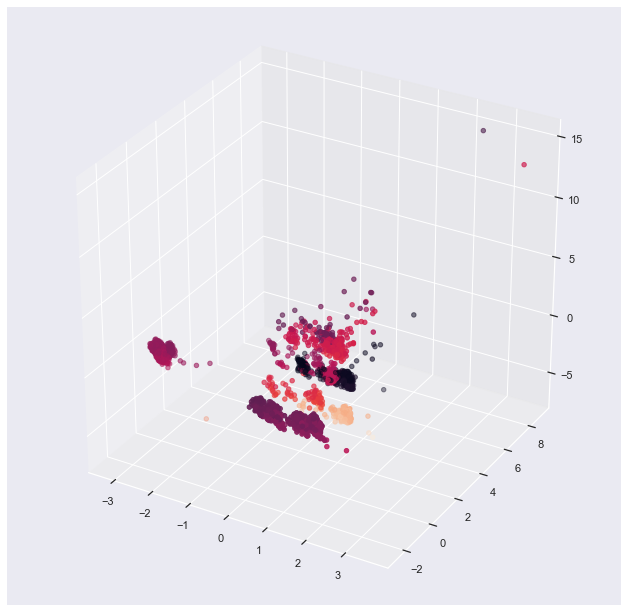

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (11, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(svd[:, 0], svd[:, 1], svd[:, 2], c = svd[:, 3])

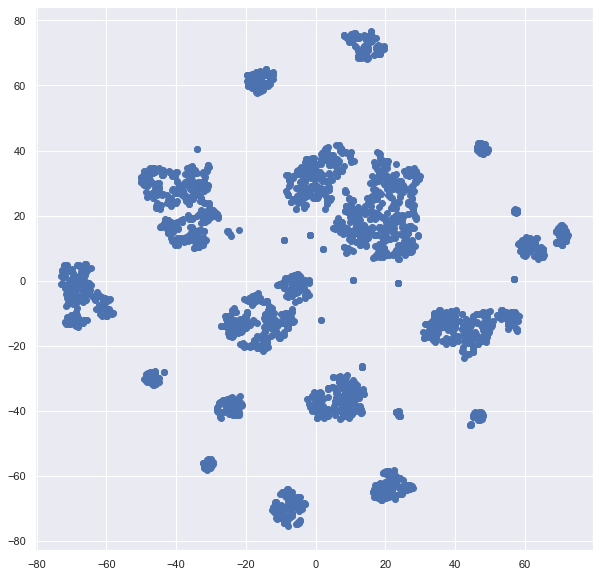

In [24]:
plt.figure(figsize=(10, 10))
plt.subplot()
plt.scatter(tsne[:, 0], tsne[:, 1])

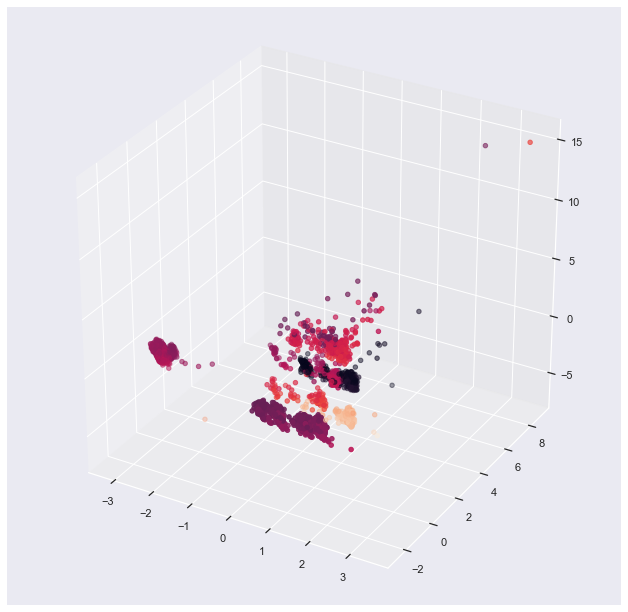

In [25]:
fig = plt.figure(figsize = (11, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca[:, 0], pca[:, 1], pca[:, 2], c = pca[:, 3])

In [26]:
# Transform to Panda Dataframe
pca = pd.DataFrame(pca)
svd = pd.DataFrame(svd)
tsne = pd.DataFrame(tsne)
vart = pd.DataFrame(vart)
slck = pd.DataFrame(slck)
slcm = pd.DataFrame(slcm)
print("Transform to Panda Dataframe Complete")

Transform to Panda Dataframe Complete


# Model

In [27]:
# Model Imports
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

In [28]:
# Scoring fonction
score_dir = 'scoring_program/'
path.append(score_dir)
from libscores import get_metric
metric_name, scoring_function = get_metric()
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [29]:
# Model List
voter1 = GradientBoostingRegressor()
voter2 = RandomForestRegressor()
voter3 = DecisionTreeRegressor()

model_name = [
    'KNeighbors',
    'SVR',
    'GaussianProcess',
    'ElasticNet',
    'DecisionTree',
    'RandomForest',
    'GradientBoosting',
    'Voting - GB - DT',
    'Voting - GB - DT - RF']

model_list = [
    KNeighborsRegressor(n_neighbors=5),
    svm.SVR(),
    GaussianProcessRegressor(), 
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(max_depth=9),
    GradientBoostingRegressor(),
    VotingRegressor(estimators=[('gb', voter1), ('lr', voter3)]),
    VotingRegressor(estimators=[('gb', voter1), ('rf', voter2), ('lr', voter3)])]

In [30]:
def score_data(data_test,Y,data_name) :
    res = {}
    perf = []
    X = data_test
    for i in range(len(model_list)) :
        model = model_list[i]
        s = cross_val_score(model, X, Y, cv=5, scoring=make_scorer(scoring_function))
        s = s.mean(), s.std() * 2
        print('CV score for the', model_name[i], '= %0.2f (+/- %0.2f)' %s)
        res[data_name+' - '+model_name[i]] = s[0]
        if s[0]<0:
            perf.append(0)
        else:
            perf.append(round(s[0],3))
    print('\n')
    return res,perf

In [31]:
res = {}
perf = np.ones((8,9))

print('score - data original: ')
shuffle = shuffle.iloc[:,:-1]
r,p = score_data(shuffle, Y_raw, 'data original')
res.update(r)
perf[0] = np.array(p)

print('score - data no outliers: ')
outliers = outliers.iloc[:,:-1]
r,p = score_data(outliers, Y, 'data no outliers')
res.update(r)
perf[1] = np.array(p)

print('score - data of PCA: ')
r,p = score_data(pca, Y, 'data of PCA')
res.update(r)
perf[2] = np.array(p)

print('score - data of SVD: ')
r,p = score_data(svd, Y, 'data of SVD')
res.update(r)
perf[3] = np.array(p)

print('score - data of TSNE: ')
r,p = score_data(tsne, Y_scaled, 'data of TSNE')
res.update(r)
perf[4] = np.array(p)

print('score - data of VarianceThreshold: ')
r,p = score_data(vart, Y, 'data of TSNE')
res.update(r)
perf[5] = np.array(p)

print('score - data of SelectKBest: ')
r,p = score_data(slck, Y, 'data of TSNE')
res.update(r)
perf[6] = np.array(p)

print('score - data of SelectFromModel LassoCV: ')
r,p = score_data(slcm, Y_scaled, 'data of TSNE')
res.update(r)
perf[7] = np.array(p)

score - data original: 
CV score for the KNeighbors = 0.56 (+/- 0.04)
CV score for the SVR = -0.00 (+/- 0.00)
CV score for the GaussianProcess = -2.47 (+/- 0.26)
CV score for the ElasticNet = 0.16 (+/- 0.04)
CV score for the DecisionTree = 0.88 (+/- 0.03)
CV score for the RandomForest = 0.93 (+/- 0.02)
CV score for the GradientBoosting = 0.91 (+/- 0.02)
CV score for the Voting - GB - DT = 0.92 (+/- 0.02)
CV score for the Voting - GB - DT - RF = 0.93 (+/- 0.02)


score - data no outliers: 
CV score for the KNeighbors = 0.57 (+/- 0.04)
CV score for the SVR = -0.00 (+/- 0.00)
CV score for the GaussianProcess = -2.50 (+/- 0.27)
CV score for the ElasticNet = 0.16 (+/- 0.04)
CV score for the DecisionTree = 0.89 (+/- 0.04)
CV score for the RandomForest = 0.94 (+/- 0.03)
CV score for the GradientBoosting = 0.92 (+/- 0.02)
CV score for the Voting - GB - DT = 0.92 (+/- 0.03)
CV score for the Voting - GB - DT - RF = 0.93 (+/- 0.03)


score - data of PCA: 
CV score for the KNeighbors = 0.66 (+/- 0

In [32]:
print("Best Combination: " + max(res,key=res.get))

Best Combination: data no outliers - RandomForest


In [33]:
perf = np.array(perf)
com_perf = pd.DataFrame(perf, columns=model_name, index=preprocessing_name)
com_perf.round(3).style.background_gradient(cmap='Blues')

,KNeighbors,SVR,GaussianProcess,ElasticNet,DecisionTree,RandomForest,GradientBoosting,Voting - GB - DT,Voting - GB - DT - RF
Raw data,0.564000,0.000000,0.000000,0.163000,0.883000,0.934000,0.910000,0.921000,0.931000
Remove Outliers,0.571000,0.000000,0.000000,0.164000,0.888000,0.939000,0.917000,0.925000,0.935000
PCA,0.659000,0.019000,0.000000,0.099000,0.455000,0.626000,0.591000,0.621000,0.665000
SVD,0.663000,0.019000,0.000000,0.094000,0.434000,0.617000,0.580000,0.601000,0.649000
TSNE,0.782000,0.181000,0.000000,0.006000,0.643000,0.742000,0.561000,0.711000,0.751000
VarianceThreshold,0.572000,0.000000,0.000000,0.163000,0.883000,0.938000,0.920000,0.924000,0.933000
SelectKBest,0.706000,0.004000,0.000000,0.155000,0.883000,0.936000,0.918000,0.923000,0.930000
SelectFromModel,0.773000,0.735000,0.000000,0.000000,0.880000,0.938000,0.920000,0.921000,0.929000


# Model.py Test

In [34]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)

Using scoring metric: r2_metric


In [35]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)

X_train = D.data['X_train']
Y_train = D.data['Y_train']

Info file found : /Users/shuangruichen/Desktop/Mini Projet/Code/all_data/xporters_public.info


In [41]:
d = pd.DataFrame(X_train)
d[-1] = Y_train
d

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,-1
0,0.0,267.510,0.0,0.0,40.0,85.821965,6.0,1.0,12.0,2017.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,759.0
1,0.0,293.720,0.0,0.0,90.0,72.271517,5.0,11.0,6.0,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4085.0
2,0.0,302.180,0.0,0.0,0.0,65.922514,1.0,19.0,7.0,2013.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3528.0
3,0.0,255.580,0.0,0.0,75.0,90.673493,1.0,5.0,2.0,2014.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2636.0
4,0.0,286.381,0.0,0.0,0.0,97.325080,2.0,18.0,10.0,2016.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38558,0.0,277.150,0.0,0.0,1.0,75.378949,3.0,5.0,11.0,2017.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2967.0
38559,0.0,284.640,0.0,0.0,75.0,88.848184,4.0,15.0,11.0,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5958.0
38560,0.0,288.490,0.0,0.0,1.0,85.513893,0.0,7.0,5.0,2017.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6591.0
38561,0.0,300.270,0.0,0.0,90.0,92.447464,6.0,12.0,7.0,2015.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4366.0


In [42]:
from model import model

M = model()
trained_model_name = model_dir + data_name

X_train = D.data['X_train']
Y_train = D.data['Y_train']
if not(M.is_trained) : M.fit(X_train, Y_train)                 
Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on taining examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

In [43]:
# Final check
np.vstack((Y_hat_train,Y_train))

array([[ 773.32317064, 4439.27969903, 3355.12561398, ..., 6127.35523557,
        4300.51159561, 6196.57497042],
       [ 759.        , 4085.        , 3528.        , ..., 6591.        ,
        4366.        , 5240.        ]])

In [46]:
# Write Result
from data_io import write
result_name = result_dir + data_name
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)

In [47]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

Training score for the r2_metric metric = 0.9457
Ideal score for the r2_metric metric = 1.0000


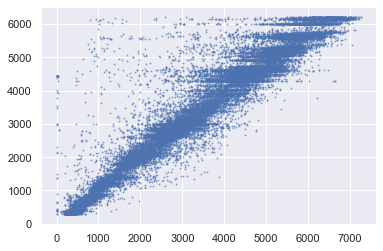

In [48]:
# Scatter plot
plt.scatter(Y_train, Y_hat_train, alpha ='0.5', s = 1 )
plt.show()

In [49]:
# Cross Valid
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


CV score (95 perc. CI): 0.94 (+/- 0.00)


# Making a submission

In [ ]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = './sample_code_submission_' + the_date + '.zip'
sample_result_submission = './sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)